# Jul 3rd, 2022 (Fig-2: Degree)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from figures.fighelper import *
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig2_Degree'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig2_Degree

## Prepare (512)

In [3]:
mice = Mice(nn)
pal, _BOLD, _CAS, _CAF = prepare_palette(0.6)

In [4]:
task = 'rest'

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    _BOLD: bt_bo,
    _CAS: bt_cas,
    _CAF: bt_caf,
}

## Degree

In [5]:
%%time

cut, se, bins, xs = cut4figs('deg', bt_dict, bt.get_booter(int(1e6)))
len(xs), len(bins)

CPU times: user 1min 11s, sys: 540 ms, total: 1min 11s
Wall time: 1min 11s


(69, 70)

In [6]:
bins

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5])

In [7]:
xs

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170., 175., 180., 185., 190., 195., 200., 205., 210., 215., 220.,
       225., 230., 235., 240., 245., 250., 255., 260., 265., 270., 275.,
       280., 285., 290., 295., 300., 305., 310., 315., 320., 325., 330.,
       335., 340., 345.])

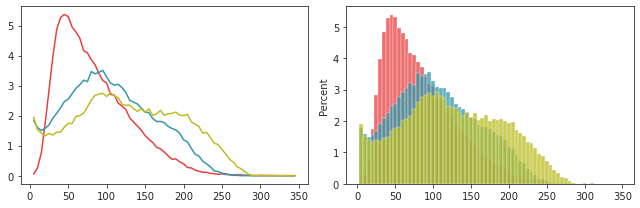

In [8]:
fig, axes = create_figure(1, 2, (9, 3))
for mode, o in bt_dict.items():
    axes[0].plot(xs, avg(cut[mode], 1), color=pal[mode])
    sns.histplot(
        data=o.run_deg[np.isfinite(o.run_deg)],
        bins=bins,
        stat='percent',
        color=pal[mode],
        ax=axes[1],
    )

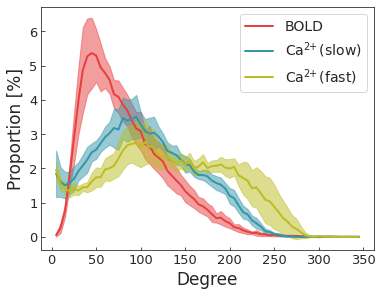

In [9]:
from figures.fig2 import dist_deg as go
fig, _ = go(cut, se, xs, True)
fig.savefig(pjoin(fig_dir, 'dist.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'dist.png'), **kws_fig)

In [10]:
deg = {
    mode: avg(o.run_deg, 1) for
    mode, o in bt_dict.items()
}

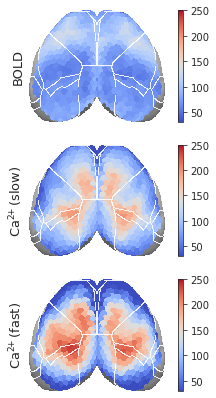

In [11]:
_ = bt.show(
    data=deg,
    figsize=(5, 7),
    vmin=30,
    vmax=250,
    add_disjoint=False,
    cmap='coolwarm',
    cbar=True,
)

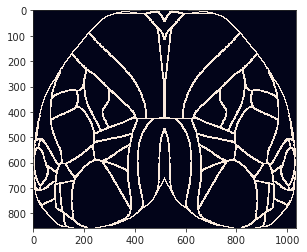

In [12]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

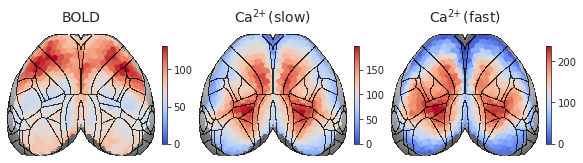

In [13]:
fig, axes = create_figure(1, 3, (8, 2.8), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, deg.items()):
    x[x == 0] = np.nan
    
    if mode == _BOLD:
        vmin = 0
    else:
        vmin = 0
    vmax = np.nanmax(x)
    
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='coolwarm',
        cbar_shrink=0.5,
        contour=contour,
        contour_cmap='Greys_r',
    )
    ax.set_title(mode, y=1.05, fontsize=14)
remove_ticks(axes)

# fig.savefig(pjoin(fig_dir, 'ctx.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

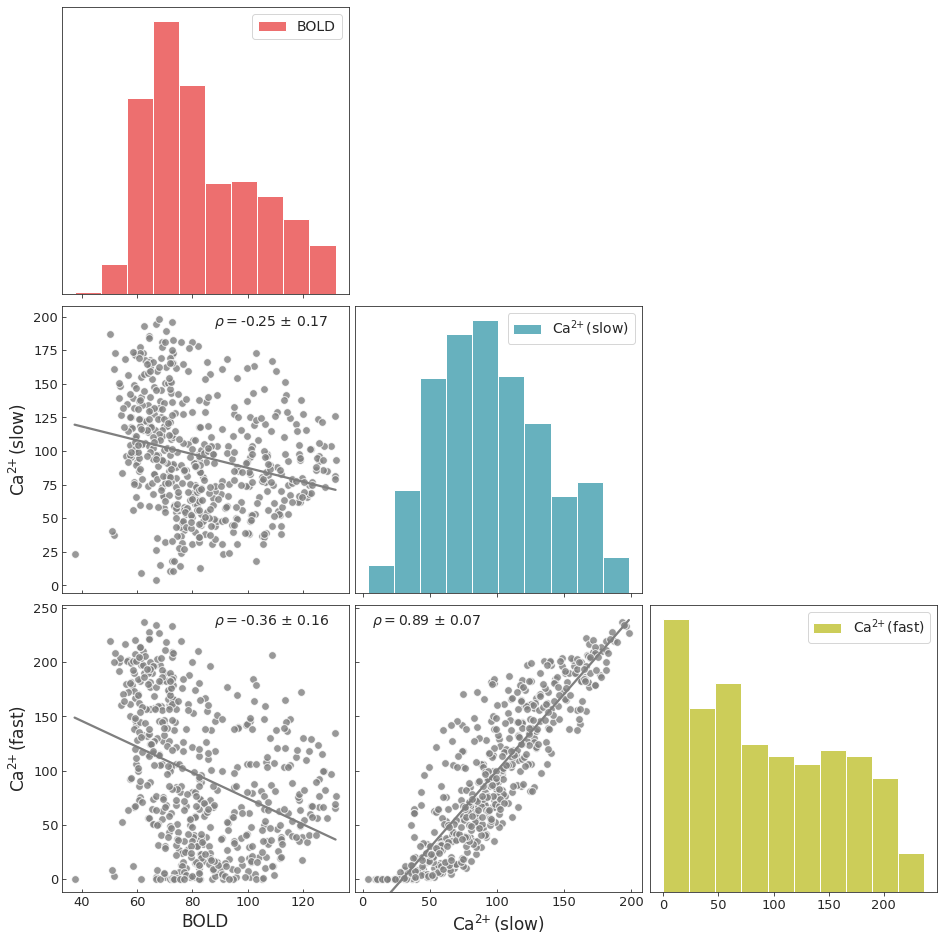

CPU times: user 21min 12s, sys: 39.9 s, total: 21min 52s
Wall time: 21min 37s


In [14]:
%%time

fig, _ = pairwise(
    attr='deg',
    bt_dict=bt_dict,
    n_resamples=int(1e6),
)
fig.savefig(pjoin(fig_dir, 'pairwise.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'pairwise.png'), **kws_fig)

In [15]:
for i, fig_name in {0: 'BOLD', 1: 'CAS', 2: 'CAF'}.items():
    fig, ax = create_figure(1, 1, (3, 2.5), tight_layout=False, constrained_layout=True)
    mode, x = list(deg.items())[i]
    x[x == 0] = np.nan
    
    if mode == _BOLD:
        vmin = 0
    else:
        vmin = 0
    vmax = np.nanmax(x)
    
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='coolwarm',
        cbar_shrink=0.7,
        contour=contour,
        contour_cmap='Greys_r',
    )
    
    ax.set_title(mode, y=1.05, fontsize=14)
    remove_ticks(ax)
    
    # fig.savefig(pjoin(fig_dir, f'ctx_{fig_name}.pdf'), **kws_fig)
    fig.savefig(pjoin(fig_dir, f'ctx_{fig_name}.png'), **kws_fig)
    
    plt.close()

## Old stuff (ignore please)

In [22]:
x = np.concatenate([
    np.expand_dims(bt_cas.run_deg, -2),
    np.expand_dims(bt_caf.run_deg, -2),
], axis=-2)
x.shape

(10, 3, 4, 2, 542)

In [23]:
sim = np_nans((10, 3, 4, 1))
for i, j, k in itertools.product(range(10), range(3), range(4)):
    _x = x[i, j, k]
    good = np.isnan(_x).sum(0) == 0
    if not good.sum():
        continue
    d = sp_dist.pdist(_x[:, good], metric='correlation').item()
    if np.isnan(d):
        continue
    sim[i, j, k] = dist2sim(d)

In [24]:
avg(sim, 1)

array([0.68050052])

<AxesSubplot:ylabel='Count'>

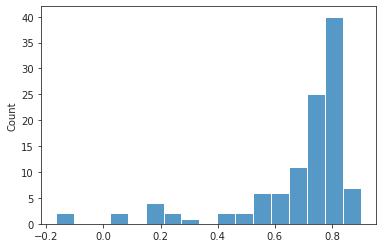

In [25]:
sns.histplot(sim.ravel())

In [26]:
low_sim = [(i, j, k) for i, j, k, _ in zip(*np.where(sim < 0.4))]
low_sim = [k for k, v in bt_cas.address.items() if v in low_sim]
low_sim

[
    'sub-SLC04_ses-1_run-1',
    'sub-SLC04_ses-1_run-5',
    'sub-SLC04_ses-1_run-7',
    'sub-SLC04_ses-2_run-5',
    'sub-SLC05_ses-1_run-5',
    'sub-SLC05_ses-2_run-7',
    'sub-SLC07_ses-2_run-1',
    'sub-SLC08_ses-2_run-5',
    'sub-SLC09_ses-1_run-5',
    'sub-SLC09_ses-2_run-1',
    'sub-SLC10_ses-2_run-5'
]

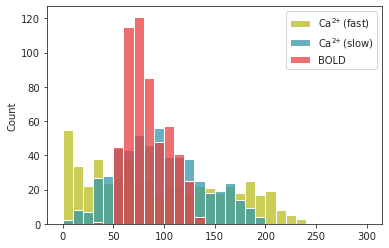

In [27]:
bins = np.linspace(0, 300, 31)
sns.histplot(avg(bt_caf.run_deg, 1), color=pal[_CAF], bins=bins, label=_CAF)
sns.histplot(avg(bt_cas.run_deg, 1), color=pal[_CAS], bins=bins, label=_CAS)
sns.histplot(avg(bt_bo.run_deg, 1), color=pal[_BOLD], bins=bins, label=_BOLD)
plt.legend();